# 0 . Les imports

In [11]:
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import datasets, transforms, models
from torchvision.models import resnet18
import numpy as np
from PIL import Image
import torchvision
from tqdm import tqdm
from torchvision.datasets import ImageFolder

chemin_dossier_images = "./data"
chemin_dossier_images_affiche = "./data/DAM"
chemin_test = "./data/test_image_headmind"

# 1 . Visualisation et analyse des données

In [2]:
def afficher_images_dossier(dossier):
    if not os.path.exists(dossier):
        print(f"Le dossier '{dossier}' n'existe pas.")
        return

    fichiers = os.listdir(dossier)
    cpt = 0
    for fichier in fichiers:
        if cpt>=10:
            break
        chemin_complet = os.path.join(dossier, fichier)
        if os.path.isfile(chemin_complet) and fichier.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            print(f"Affichage de l'image : {fichier}")
            img = mpimg.imread(chemin_complet)
            plt.imshow(img)
            plt.axis('off') 
            plt.show()
        cpt+=1

Affichage de l'image : 010M03A1116X9000.jpeg


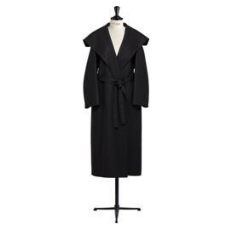

Affichage de l'image : 010M09A1101X0863.jpeg


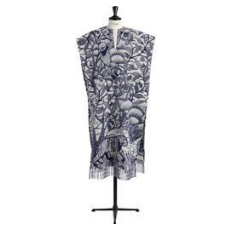

Affichage de l'image : 010M27A0006X0200.jpeg


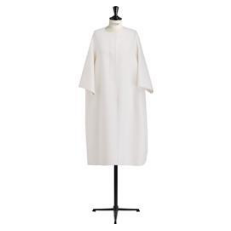

Affichage de l'image : 011A11A1166X4150.jpeg


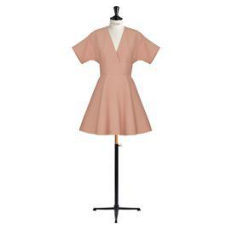

Affichage de l'image : 011A11A1166X9000.jpeg


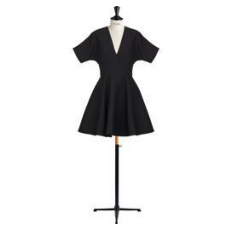

Affichage de l'image : 011B13A6014X0200.jpeg


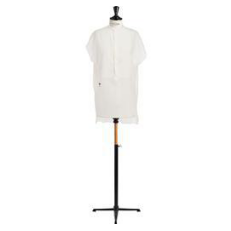

Affichage de l'image : 011B48A3874X0863.jpeg


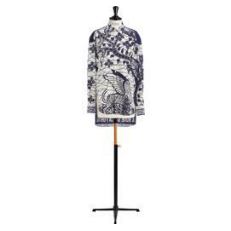

Affichage de l'image : 011D01A1166X5645.jpeg


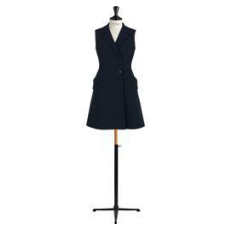

Affichage de l'image : 011D01A1166X9000.jpeg


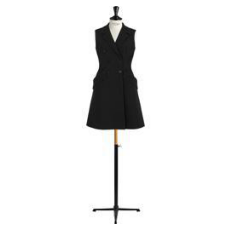

Affichage de l'image : 011D02A1166X3250.jpeg


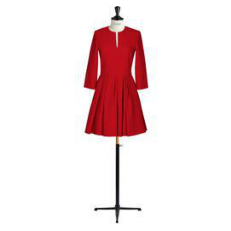

In [3]:
afficher_images_dossier(chemin_dossier_images_affiche)

# 2 . Chargement et traitement des données pour notre modèle

In [4]:
# On crée une class custom pour labelliser nos images

class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_paths = [os.path.join(folder_path, img_name) for img_name in os.listdir(folder_path)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        # On utilise le titre de l'image comme label
        label = os.path.splitext(os.path.basename(img_path))[0]

        if self.transform:
            img = self.transform(img)

        return img, label   

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    #transforms.RandomErasing(),
    transforms.ToTensor(),
])


trainset = CustomDataset(chemin_dossier_images_affiche, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)

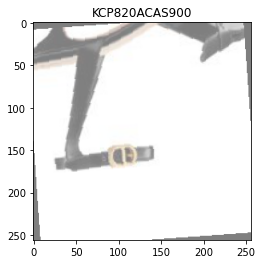

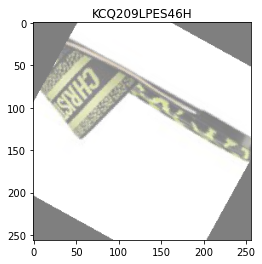

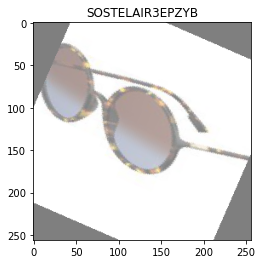

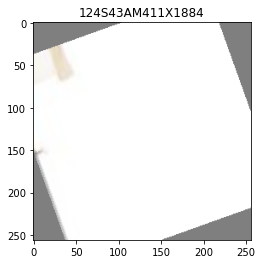

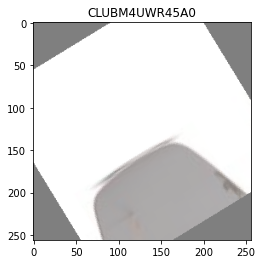

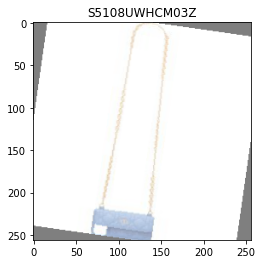

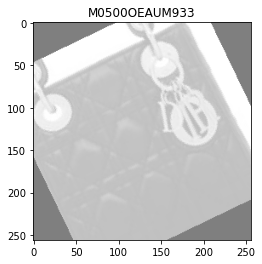

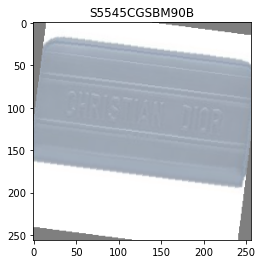

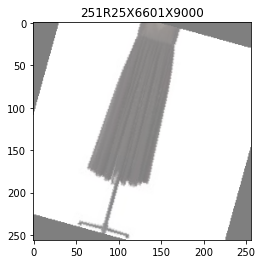

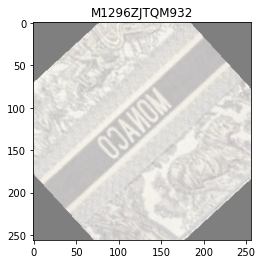

In [5]:
def imshow(img,label):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(label)
    plt.show()

for i in range(10):
    data_iter = iter(train_loader)
    images, labels = data_iter.next() 
    imshow(torchvision.utils.make_grid(images[i]),labels[i])

# 3 . Construction et entrainement du modèle 

In [6]:
"""
    Ici, j'ai pris un modèle quelconque qui n'est pas correct qui utilise le transfert learning juste pour illustrer l'utilisation de 
    nos données. C'est juste pour aller + vite quand on utilisera notre vraie modèle.
"""

class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.resnet = resnet18(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

class_to_idx = {cls: idx for idx, cls in enumerate(sorted(set(label for _, label in trainset)))}
num_classes = len(class_to_idx)

model = CustomResNet(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        optimizer.zero_grad()
        outputs = model(inputs)

        # On convertit les labels en indices numériques
        numeric_labels = torch.tensor([class_to_idx[label] for label in labels])

        loss = criterion(outputs, numeric_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss}')

print('Entraînement terminé.')

Epoch 1/5: 100%|███████████████████████████████████████████████████████████████████████| 87/87 [10:02<00:00,  6.92s/it]


Epoch [1/5], Loss: 9.447513689940003


Epoch 2/5: 100%|███████████████████████████████████████████████████████████████████████| 87/87 [09:02<00:00,  6.23s/it]


Epoch [2/5], Loss: 8.271525196645452


Epoch 3/5: 100%|███████████████████████████████████████████████████████████████████████| 87/87 [09:06<00:00,  6.28s/it]


Epoch [3/5], Loss: 8.178467712183108


Epoch 4/5: 100%|███████████████████████████████████████████████████████████████████████| 87/87 [09:48<00:00,  6.77s/it]


Epoch [4/5], Loss: 8.140806620148407


Epoch 5/5: 100%|███████████████████████████████████████████████████████████████████████| 87/87 [10:17<00:00,  7.10s/it]

Epoch [5/5], Loss: 8.098439819511325
Entraînement terminé.


# 4 . Evaluation 

In [16]:
"""
    Ici on fait toute la partie calcule de similarité pour évaluer notre modèle. 

"""

'\n    Ici on fait toute la partie calcule de similarité pour évaluer notre modèle. \n\n'

# 5. Conclusion